In [1]:
# The following is from "big run"
import sys
sys.path.append('..')
from lib import *
import pandas as pd
import numpy as np

In [2]:
lsa_np = np.load('../data/parsed/lsa_output.npy')

In [3]:
metadata = pd.read_pickle('../data/parsed/pickles/pickled_data_test.pickle')
metadata = metadata.loc[metadata['Scenario'] == '401']
metadata = metadata.reset_index(drop=True)

In [4]:
lsa_df = pd.DataFrame(lsa_np)

In [5]:
df = pd.concat([metadata, lsa_df], axis=1, join_axes=[metadata.index])
df = df.loc[df['Label'] != '-1']
df = df.reset_index(drop=True)

In [6]:
cat_features = ['To','From']
features = list(range(100))
features.extend(cat_features + ['Date'])

df = df[features + ['Label']]

In [7]:
def cross_val_rnf_incremental(num_trees, df, tries, num_increments, random_seed, cat_features, overall_training_ratio, 
                              initial_training_ratio, increment_size):
    ''' 
        Testing for incremental learning. 
        Start some small subset of the dataset and increment with 10 more, see if there's an improvement.
        args:
            df (dataframe)
            tries (int) number of times to repeat the test
            num_increments (int) number of times to incrementally train a model
            random_seed (some object)
            cat_features (list) required to initalize forest
            overall_training_ratio (float) fraction of df to use as the training set
            initial_training_ratio (float) fraction of df to use as the training set before any increments
            increment_size (int) number of new rows to use per incremental step
    '''
    if (overall_training_ratio >= 1):
        print("The training set should be samller than the dataset")
        return
    if (initial_training_ratio >= 1):
        print("The initial training set should be smaller than the dataset")
        return
    if (initial_training_ratio >= overall_training_ratio):
        print("The initial training set should be smaller than the overall training set")
        return
    
    
        
    dataset_size = df.shape[0]
    initial_train_size = math.floor(dataset_size * initial_training_ratio)
    overall_train_size = math.floor(dataset_size * overall_training_ratio)
    test_size = dataset_size - overall_train_size;
    
    increment_limit = (overall_train_size - initial_train_size) / increment_size
    increment_limit = int(math.floor(increment_limit))
    
    if num_increments > increment_limit:
        print('too many increments specified ({}), running with the max possible: ({})'.format(num_increments, increment_limit))
        num_increments = increment_limit;
    for i in range(tries):
        cur_max = initial_train_size
        shuffled_df = df.sample(frac=1, random_state=1)
        #shuffled_df = shuffle(df, random_state=random_seed)
        shuffled_df = shuffled_df.reset_index(drop=True)
        
        
        
    
        
        # initial fit
        initial_df = shuffled_df[0:cur_max]
        n_features = math.floor(math.sqrt(df.shape[1]))
        tree_depth = 20
        forest = RNF(initial_df, num_trees, tree_depth, random_seed, n_features, cur_max, cat_features)
        forest.fit()
        print(type(forest.trees[0].head.rows[0]))
        print(forest.trees[0].head.rows)
        
        print(forest.trees[0] == forest.trees[1])
        
        score = 0
        # This is the answer key
        labels = [row["Label"] for index, row in shuffled_df[-test_size:].iterrows()]
        
        print("LABELS:")
        print(labels)        
        
        predicted_classes = forest.predict(shuffled_df[-test_size:])[1]
        print("predicted_classes:")
        print(predicted_classes)
        score = sum( [ 1 for i in range(len(predicted_classes)) if predicted_classes[i] == labels[i]])
        print('score before incremental training: ' + str(score / test_size))
        
        
        for j in range(1, num_increments + 1):
            last = initial_train_size + j * increment_size
            # print(last)
            
            # put this into RNF later!!!
            forest.n_max_input = last
            
            forest.update(shuffled_df[:last])
            # print(type(forest.trees[0].head.rows[0]))
            
            score = 0
            labels = [row["Label"] for index, row in shuffled_df[-test_size:].iterrows()]
            predicted_classes = forest.predict(shuffled_df[-test_size:])[1]
            print("predicted_classes:")
            print(predicted_classes)
            score = sum( [ 1 for i in range(len(predicted_classes)) if predicted_classes[i] == labels[i]])
            print('score at increment ' + str(j) + ': ' + str(score / test_size))

In [7]:
# TODO: test tree behavior in ml_master when given .2 of training set to work with
# TODO: rather than making each tree its own process, divide the number of trees by the number of cores, and create
#       a list of trees that can be processed linearly in its own core.
# TODO: double check the order of things that are added to 'r' when doing result.get(), and if it matters in this 
#       application
# TODO: when working, test improvement rate when giving feedback for only things that it is very unsure on
# TODO: I think multiprocessing will need to be done at the node level. 
#       Forest.fit multiprocesses to call tree.fit for each tree
#       tree.fit just calls self.head.split
#       each splitting node creates a pool of size two, for left and right. (recursively)

num_trees = 2
tries = 1
num_increments = 999
# random_seed = 600
random_seed = None
overall_training_ratio = .8
initial_training_ratio = .2
increment_size = 10
cross_val_rnf_incremental(num_trees, df, tries, num_increments, random_seed,cat_features, overall_training_ratio,
                          initial_training_ratio, increment_size)

TypeError: cross_val_rnf_incremental() takes 4 positional arguments but 9 were given

In [7]:
# test_forest = RNF(df, 1, 20, None, math.floor(math.sqrt(df.shape[1])), 200, ['To','From'])
test_forest = RNF(df, 16, 100, None, df.shape[1] - 3, math.floor(math.sqrt(df.shape[0])), ['To','From'])

In [8]:
test_forest.fit()

8
10
8
8
10
10
6
10
8
6
8
8
10
8
6
8
done!


In [16]:
test_forest.trees[1].visualize()

'digraph Tree {\nnode [shape=box];\n2245284199 [label="samples = 26\nratio = [0.4230769230769231, 0.5769230769230769]"];\n}'

In [14]:
%%bash 
cd vis
# mac xargs syntax seems different from linux
ls *.dot | xargs -I '{}' dot '{}' -Tpng -O
ls *.dot | xargs -I '{}' dot '{}' -Tsvg -O
dot -Tpng tree.dot -o tree.png
dot -Tsvg tree.dot -o tree.svg

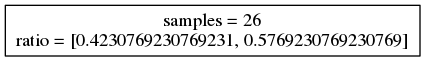

In [15]:
from IPython.display import Image
Image(filename='vis/tree.png')